<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/clickbait_image_tfrec_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [223]:
!pip install -q -U tensorflow-addons

#Imports

In [224]:
from __future__ import absolute_import, division, print_function
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

from importlib import reload



#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')


import tf_dataset_helpers as dh
import vgg16_model_helper as vggh

from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh
from vgg16_model_helper import vgg16_model

#reload(mh)  # reload script if any changes there
#reload(dh)
#reload(vh)
#reload(vggh)




#Configurations

##Configs

In [225]:
PATH_OUTPUT = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/tfrec/tfrec_data/'

TARGET_SIZE = [180, 180]
CLASSES = [b'nonclickbaits', b'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180


In [226]:
#Save weights
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints'
vgg16_v1_model_weight_path = os.path.join(checkpoint_filepath, 'vgg16_v1_weights.h5')
vgg16_v2_model_weight_path = os.path.join(checkpoint_filepath, 'vgg16_v2_weights.h5')
vgg16_v3_model_weight_path = os.path.join(checkpoint_filepath, 'vgg16_v3_weights.h5')

vgg16_v1_model_aug_weight_path = os.path.join(checkpoint_filepath, 'vgg16_v1_aug_weights.h5')

#Save model
MODEL_SAVE_PATH ='/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models'
vgg16_v1_model_path = os.path.join(MODEL_SAVE_PATH, 'vgg16_v1_model')
vgg16_v2_model_path = os.path.join(MODEL_SAVE_PATH, 'vgg16_v2_model')
vgg16_v3_model_path = os.path.join(MODEL_SAVE_PATH, 'vgg16_v3_model')

vgg16_v1_model_aug_path = os.path.join(MODEL_SAVE_PATH, 'vgg16_v1_aug_model')

In [227]:
#instantiate read_data utility
read_data = read_tfrec_data(PATH_OUTPUT, TARGET_SIZE=TARGET_SIZE, MODE=0, SHUFFLE_BUFFER=1000)

# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()

validation_steps = int(15572 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15572 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 12 training files , 2 validation files and 2 test files
With a batch size of 32, there will be 364 batches per training epoch and 60 batch(es) per validation run.


##Utilities

In [228]:
#@title "LR EXPLORATION"
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)



class LrRangeFinder(tf.keras.callbacks.Callback):
  def __init__(self, start_lr, end_lr):
    super().__init__()
    self.start_lr = start_lr
    self.end_lr = end_lr 
       
  def on_train_begin(self, logs={}):
    self.lrs = []
    self.losses = []
    tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
    
    n_steps = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
    n_steps *= self.params['epochs']
    self.by = (self.end_lr - self.start_lr) / n_steps
      

  def on_batch_end(self, batch, logs={}):
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    self.lrs.append(lr)
    self.losses.append(logs.get('loss'))
    lr += self.by
    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [229]:
#@title "Visualization:- RUN ME"
def display_9_images_from_batched_dataset(dataset, CLASSES):
  plt.figure(figsize=(13,13))
  subplot=331
  for image, label in display_train_ds:
    for i in range(len(image.numpy())):
      plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image[i].numpy().astype(np.uint8))
      plt.title(CLASSES[label[i].numpy()], fontsize=16)
      subplot += 1
      if i==8:
        break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [230]:
#@title "Callbacks - RUN ME"
def get_callbacks(checkpoint_path):
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        verbose=1, 
                                        patience=5, 
                                        mode='min', 
                                        restore_best_weights=True)

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.2,
                                                   patience=5,
                                                   min_lr=1e-5,
                                                   verbose=1)

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath=checkpoint_path,
     save_weights_only=True,
     monitor='val_loss',
     mode='min',
     verbose=1,
     save_best_only=True)
  
  return [es, reduce_lr, model_checkpoint_callback]


#Load data

In [231]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)


In [232]:
# instantiate the datasets
train_ds = read_data.get_batched_dataset(training_filenames, train=True)
train_dataset = train_ds.map(_normalize_img)
val_ds = read_data.get_batched_dataset(validation_filenames, train=False)
val_ds = val_ds.map(_normalize_img)
test_ds = read_data.get_batched_dataset(testing_filenames, train=False)
test_ds = test_ds.map(_normalize_img)

#Viusualize data

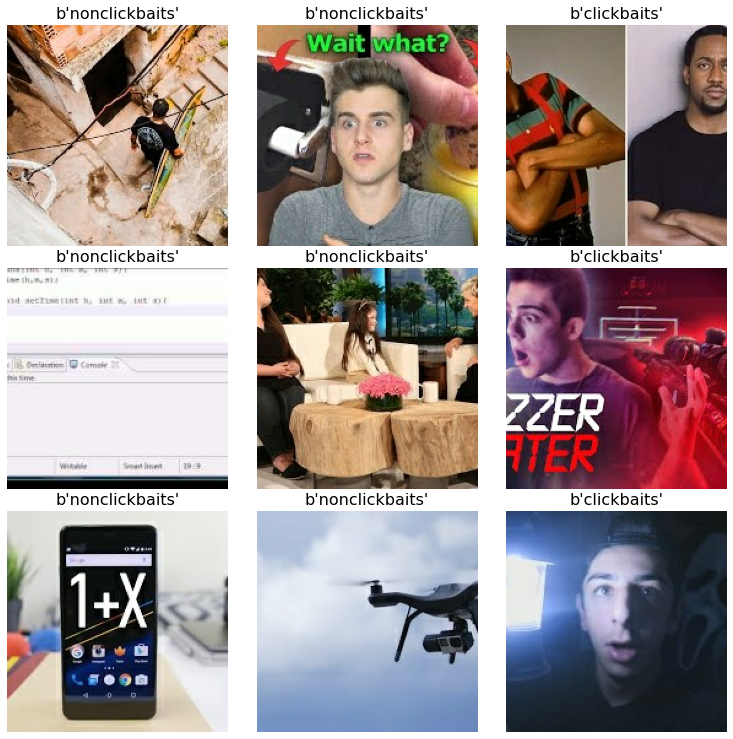

In [233]:
display_train_ds = train_ds.take(1)
display_9_images_from_batched_dataset(display_train_ds, CLASSES)

#Build model

###V1

In [234]:
model_p = vgg16_model(IMG_SIZE=(WIDTH, HEIGHT),
                      augmentation=False,
                      weight_normalize=False, 
                      add_regularizer=False, 
                      add_dropout=True, 
                      dense_activation='relu')

vgg16_v1 = model_p.vgg16_v1()
vgg16_v1.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_160 (InputLayer)       [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_39  (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add_39 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_196 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_156 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 256)               131

###V2

In [235]:
model_p = vgg16_model(IMG_SIZE=(WIDTH, HEIGHT),
                      augmentation=False,
                      weight_normalize=False, 
                      add_regularizer=False, 
                      add_dropout=True, 
                      dense_activation='relu')
vgg16_v2 = model_p.vgg16_v2()
vgg16_v2.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_164 (InputLayer)       [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_40  (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add_40 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_201 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_160 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 256)               131

###V3

In [236]:
model_p = vgg16_model(IMG_SIZE=(WIDTH, HEIGHT),
                      augmentation=False,
                      weight_normalize=False, 
                      add_regularizer=False, 
                      add_dropout=True, 
                      dense_activation='relu')
vgg16_v3 = model_p.vgg16_v3()
vgg16_v3.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_168 (InputLayer)       [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_41  (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add_41 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_206 (Dense)            (None, 1024)              13108224  
_________________________________________________________________
dropout_164 (Dropout)        (None, 1024)              0  

###V4

In [237]:
model_p = vgg16_model(IMG_SIZE=(WIDTH, HEIGHT),
                      augmentation=True,
                      dense_activation='relu')

vgg16_v1_aug = model_p.vgg16_v1()
vgg16_v1_aug.summary()

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_172 (InputLayer)       [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_42 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_42  (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add_42 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
weight_normalization_40 (Wei (None, 512)               525825    
_________________________________________________________________
dropout_168 (Dropout)        (None, 512)               0  

#Training

###V1

In [238]:
callbacks = get_callbacks(vgg16_v1_model_weight_path)
if os.path.exists(vgg16_v1_model_weight_path):
  print('loading weight')
  vgg16_v1.load_weights(vgg16_v1_model_weight_path)

vgg16_v1, vgg16_v1_history = mh.compile_train_model( vgg16_v1,
                                                     train_ds, 
                                                     val_ds,
                                                     steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=50,
                                                     CALLBACKS = callbacks,
                                                     save_model = True,
                                                     model_save_path=vgg16_v1_model_path)

loading weight
Epoch 1/50
364/364 [==============================] - 41s 106ms/step - loss: 0.8840 - tp: 1419.1479 - fp: 1284.4740 - tn: 2941.6521 - fn: 2130.6384 - accuracy: 0.5594 - precision: 0.5142 - recall: 0.3587 - auc: 0.5570 - prc: 0.5152 - val_loss: 0.6882 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5142 - val_prc: 0.4630

Epoch 00001: val_loss improved from inf to 0.68818, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints/vgg16_v1_weights.h5
Epoch 2/50
364/364 [==============================] - 39s 106ms/step - loss: 0.8796 - tp: 1407.8027 - fp: 1305.6959 - tn: 1856.4630 - fn: 1285.9507 - accuracy: 0.5504 - precision: 0.5077 - recall: 0.5072 - auc: 0.5665 - prc: 0.5253 - val_loss: 0.6882 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_

###V2

In [239]:
callbacks = get_callbacks(vgg16_v2_model_weight_path)
if os.path.exists(vgg16_v2_model_weight_path):
  print('loading weight')
  vgg16_v2.load_weights(vgg16_v2_model_weight_path)

vgg16_v2, vgg16_v2_history = mh.compile_train_model( vgg16_v2,
                                                     train_ds, 
                                                     val_ds,
                                                     steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=50,
                                                     CALLBACKS = callbacks,
                                                     save_model = True,
                                                     model_save_path=vgg16_v2_model_path)

loading weight
Epoch 1/50
364/364 [==============================] - 43s 111ms/step - loss: 7.7977 - tp: 1451.8247 - fp: 1549.6137 - tn: 2657.5589 - fn: 2116.9151 - accuracy: 0.5308 - precision: 0.4806 - recall: 0.3673 - auc: 0.5271 - prc: 0.4804 - val_loss: 0.7430 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4982 - val_prc: 0.4424

Epoch 00001: val_loss improved from inf to 0.74296, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints/vgg16_v2_weights.h5
Epoch 2/50
364/364 [==============================] - 39s 108ms/step - loss: 6.6690 - tp: 1452.1507 - fp: 1499.6438 - tn: 1666.3890 - fn: 1237.7288 - accuracy: 0.5313 - precision: 0.4878 - recall: 0.5380 - auc: 0.5366 - prc: 0.4868 - val_loss: 0.7658 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_

###V3

In [240]:
callbacks = get_callbacks(vgg16_v3_model_weight_path)
if os.path.exists(vgg16_v3_model_weight_path):
  print('loading weight')
  vgg16_v3.load_weights(vgg16_v3_model_weight_path)

vgg16_v3, vgg16_v3_history = mh.compile_train_model( vgg16_v3,
                                                     train_ds, 
                                                     val_ds,
                                                     steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=50,
                                                     CALLBACKS = callbacks,
                                                     save_model = True,
                                                     model_save_path=vgg16_v3_model_path)

loading weight
Epoch 1/50
364/364 [==============================] - 43s 113ms/step - loss: 2.1910 - tp: 1436.1671 - fp: 1340.8164 - tn: 2880.7699 - fn: 2118.1589 - accuracy: 0.5539 - precision: 0.5102 - recall: 0.3614 - auc: 0.5548 - prc: 0.5077 - val_loss: 0.7277 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4558 - val_prc: 0.4154

Epoch 00001: val_loss improved from inf to 0.72769, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints/vgg16_v3_weights.h5
Epoch 2/50
364/364 [==============================] - 40s 110ms/step - loss: 1.7900 - tp: 1537.9507 - fp: 1295.9699 - tn: 1864.9288 - fn: 1157.0630 - accuracy: 0.5826 - precision: 0.5390 - recall: 0.5724 - auc: 0.6102 - prc: 0.5532 - val_loss: 0.7291 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_

###V4

In [241]:
callbacks = get_callbacks(vgg16_v1_model_aug_weight_path)
if os.path.exists(vgg16_v1_model_aug_weight_path):
  print('loading weight')
  vgg16_v3.load_weights(vgg16_v1_model_aug_weight_path)

vgg16_v1_aug, vgg16_v1_aug_history = mh.compile_train_model( vgg16_v1_aug,
                                                     train_ds, 
                                                     val_ds,
                                                     steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=50,
                                                     CALLBACKS = callbacks,
                                                     save_model = True,
                                                     model_save_path=vgg16_v1_model_aug_path)

Epoch 1/50
364/364 [==============================] - 47s 118ms/step - loss: 0.7712 - tp: 1421.0466 - fp: 1625.9068 - tn: 2594.1425 - fn: 2134.8164 - accuracy: 0.5188 - precision: 0.4614 - recall: 0.3631 - auc: 0.5024 - prc: 0.4609 - val_loss: 0.6980 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4983 - val_prc: 0.4465

Epoch 00001: val_loss improved from inf to 0.69802, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints/vgg16_v1_aug_weights.h5
Epoch 2/50
364/364 [==============================] - 41s 112ms/step - loss: 0.7438 - tp: 1314.3123 - fp: 1418.0603 - tn: 1745.6137 - fn: 1377.9260 - accuracy: 0.5197 - precision: 0.4721 - recall: 0.4892 - auc: 0.5279 - prc: 0.4778 - val_loss: 0.7147 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1054.0000 - val_fn: 866.0000 - val_accuracy: 0.5490 - val_precision: 

#Plot training history

###V1

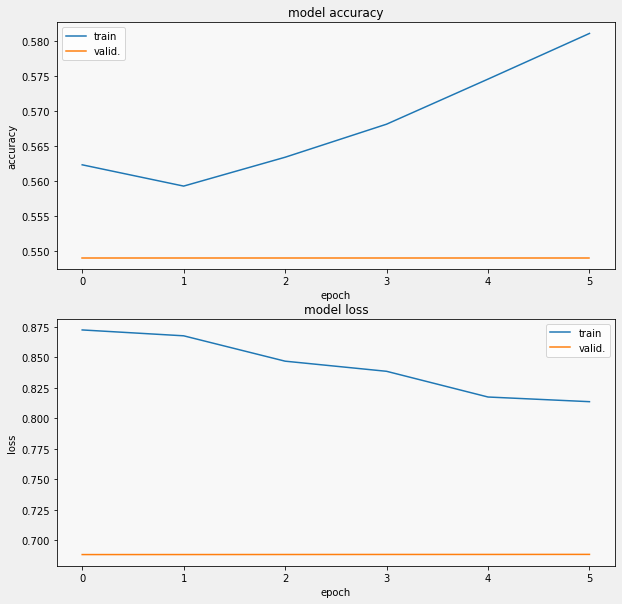

In [242]:
vh.display_training_curves(vgg16_v1_history.history['accuracy'], vgg16_v1_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(vgg16_v1_history.history['loss'], vgg16_v1_history.history['val_loss'], 'loss', 212)

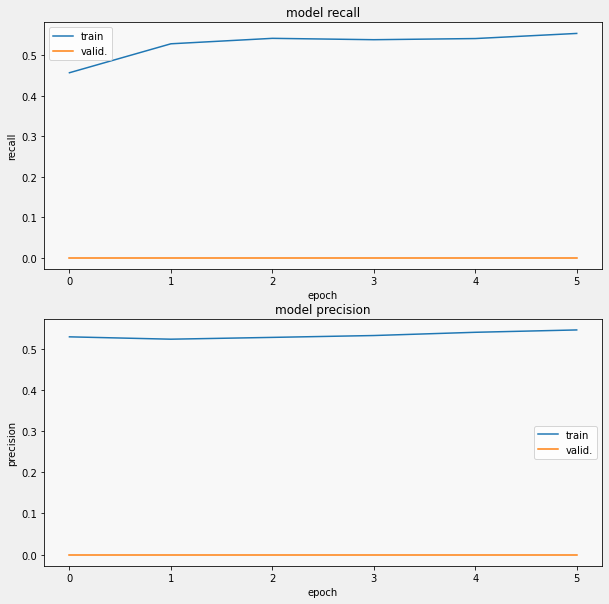

In [243]:
vh.display_training_curves(vgg16_v1_history.history['recall'], vgg16_v1_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(vgg16_v1_history.history['precision'], vgg16_v1_history.history['val_precision'], 'precision', 212)

###V2

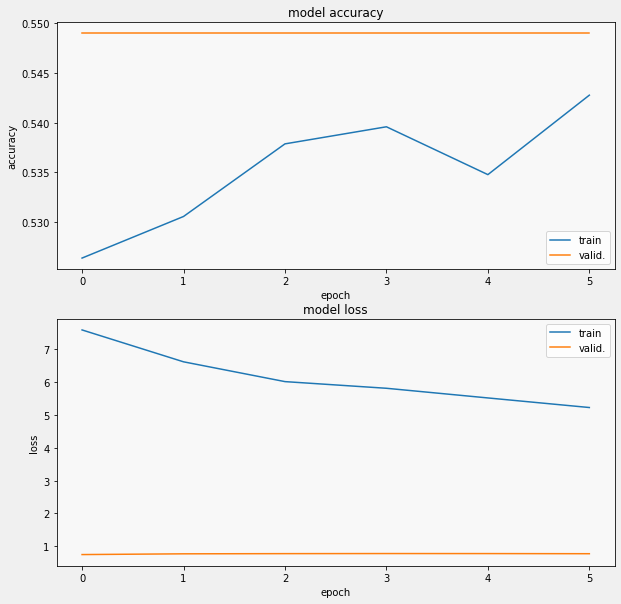

In [244]:
vh.display_training_curves(vgg16_v2_history.history['accuracy'], vgg16_v2_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(vgg16_v2_history.history['loss'], vgg16_v2_history.history['val_loss'], 'loss', 212)

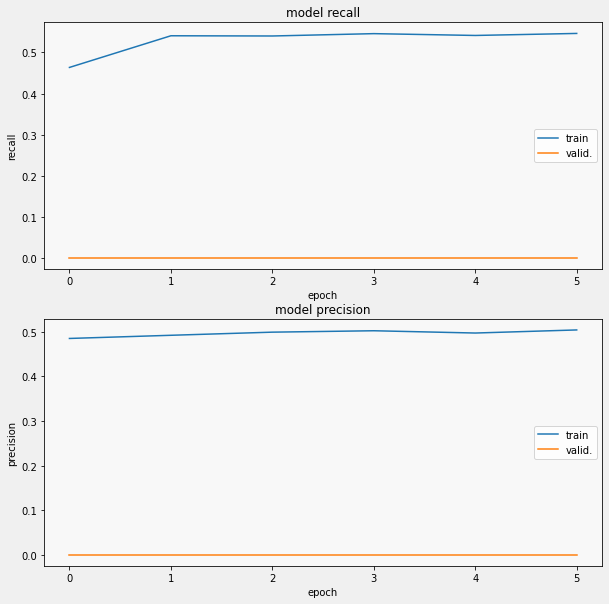

In [245]:
vh.display_training_curves(vgg16_v2_history.history['recall'], vgg16_v2_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(vgg16_v2_history.history['precision'], vgg16_v2_history.history['val_precision'], 'precision', 212)

###V3

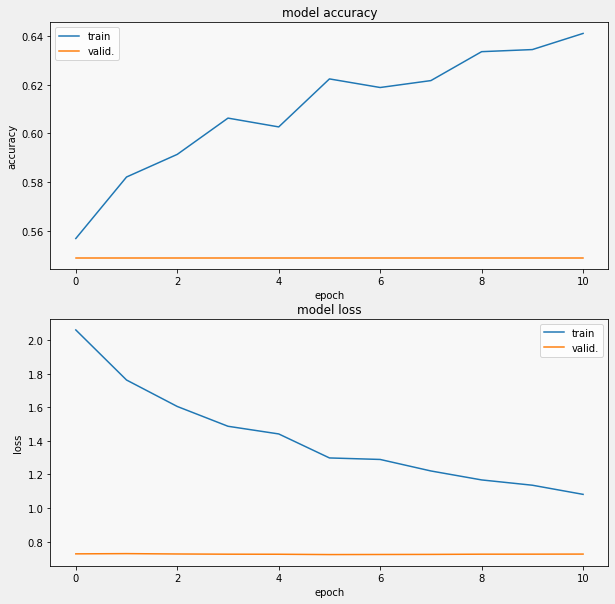

In [246]:
vh.display_training_curves(vgg16_v3_history.history['accuracy'], vgg16_v3_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(vgg16_v3_history.history['loss'], vgg16_v3_history.history['val_loss'], 'loss', 212)

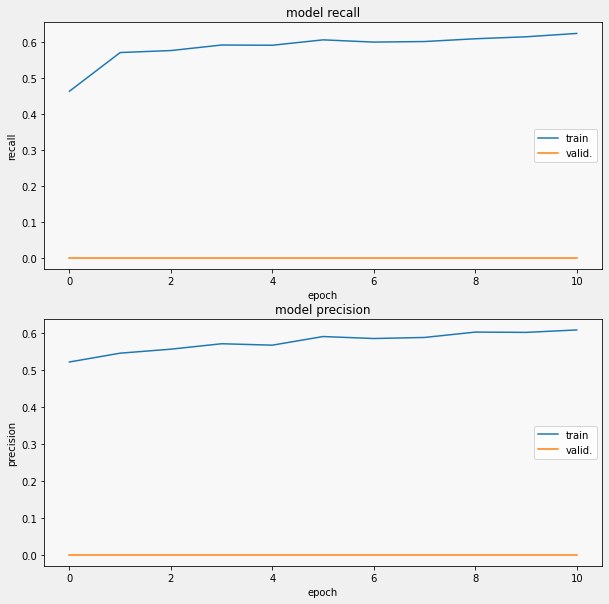

In [250]:
vh.display_training_curves(vgg16_v3_history.history['recall'], vgg16_v3_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(vgg16_v3_history.history['precision'], vgg16_v3_history.history['val_precision'], 'precision', 212)

###V4

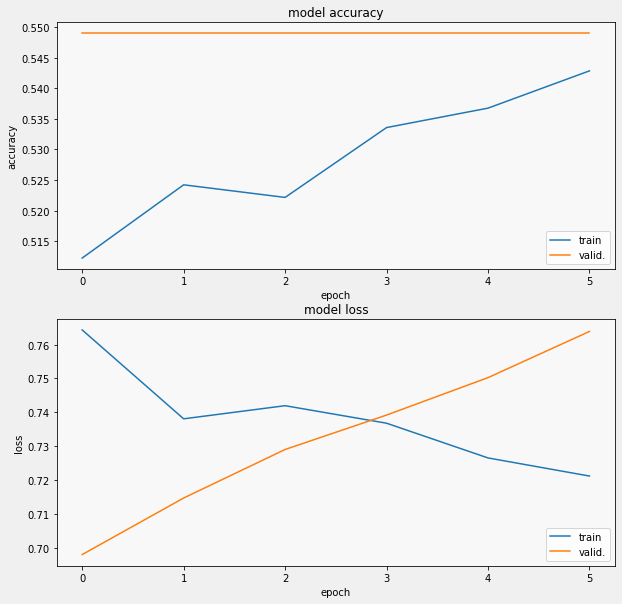

In [248]:
vh.display_training_curves(vgg16_v1_aug_history.history['accuracy'], vgg16_v1_aug_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(vgg16_v1_aug_history.history['loss'], vgg16_v1_aug_history.history['val_loss'], 'loss', 212)

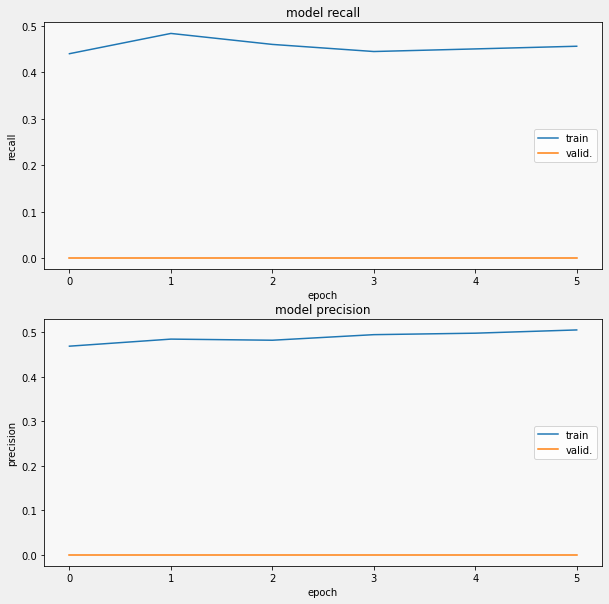

In [251]:
vh.display_training_curves(vgg16_v1_aug_history.history['recall'], vgg16_v1_aug_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(vgg16_v1_aug_history.history['precision'], vgg16_v1_aug_history.history['val_precision'], 'precision', 212)

#Model evaluation and Predictions

###V1

61/61 [==============================] - 7s 98ms/step - loss: 0.6900 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1052.0000 - fn: 896.0000 - accuracy: 0.5400 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5068 - prc: 0.4639
loss :  0.6900327801704407
tp :  0.0
fp :  0.0
tn :  1052.0
fn :  896.0
accuracy :  0.5400410890579224
precision :  0.0
recall :  0.0
auc :  0.5068163275718689
prc :  0.46387457847595215

Accuracy: 0.555208
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
ROC AUC: 0.500000
[[533   0]
 [427   0]]
Non clickbaits Detected (True Negatives):  533
Non-Clickbaits Detected as Clickbaits (False Positives):  0
Clickbaits Detected as Non-clickbaits (False Negatives):  427
Clickbaits Detected (True Positives):  0
Total Non-clickbaits:  533
Total Clickbaits:  427



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


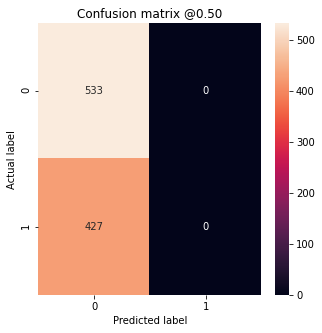

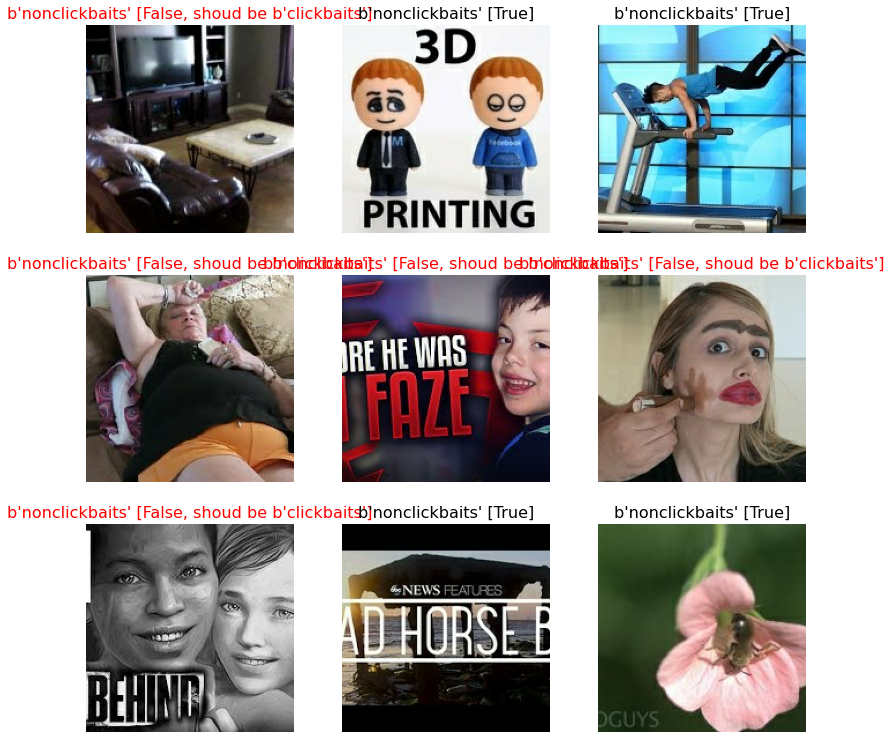

In [252]:
saved_model_vgg16_v1 = keras.models.load_model(vgg16_v1_model_path)
results = saved_model_vgg16_v1.evaluate(test_ds)

for name, value in zip(saved_model_vgg16_v1.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_vgg16_v1,test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

###V2

61/61 [==============================] - 7s 98ms/step - loss: 0.7502 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1052.0000 - fn: 896.0000 - accuracy: 0.5400 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4978 - prc: 0.4535
loss :  0.7501968145370483
tp :  0.0
fp :  0.0
tn :  1052.0
fn :  896.0
accuracy :  0.5400410890579224
precision :  0.0
recall :  0.0
auc :  0.49780917167663574
prc :  0.4534652531147003

Accuracy: 0.555208
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
ROC AUC: 0.500000
[[533   0]
 [427   0]]
Non clickbaits Detected (True Negatives):  533
Non-Clickbaits Detected as Clickbaits (False Positives):  0
Clickbaits Detected as Non-clickbaits (False Negatives):  427
Clickbaits Detected (True Positives):  0
Total Non-clickbaits:  533
Total Clickbaits:  427



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


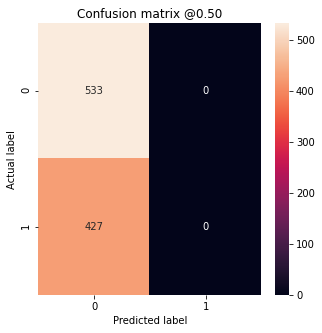

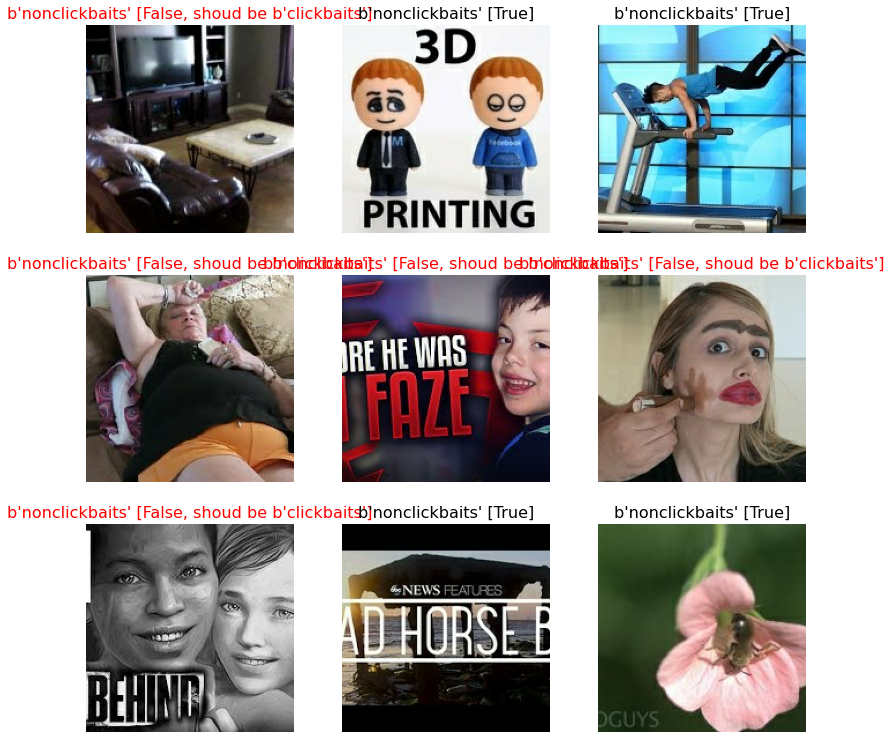

In [253]:
saved_model_vgg16_v2 = keras.models.load_model(vgg16_v2_model_path)
results = saved_model_vgg16_v2.evaluate(test_ds)

for name, value in zip(saved_model_vgg16_v2.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_vgg16_v2,test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

###V3

61/61 [==============================] - 7s 97ms/step - loss: 0.7304 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1052.0000 - fn: 896.0000 - accuracy: 0.5400 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4744 - prc: 0.4337
loss :  0.7303916811943054
tp :  0.0
fp :  0.0
tn :  1052.0
fn :  896.0
accuracy :  0.5400410890579224
precision :  0.0
recall :  0.0
auc :  0.4744057059288025
prc :  0.4337376356124878

Accuracy: 0.555208
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
ROC AUC: 0.500000
[[533   0]
 [427   0]]
Non clickbaits Detected (True Negatives):  533
Non-Clickbaits Detected as Clickbaits (False Positives):  0
Clickbaits Detected as Non-clickbaits (False Negatives):  427
Clickbaits Detected (True Positives):  0
Total Non-clickbaits:  533
Total Clickbaits:  427



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


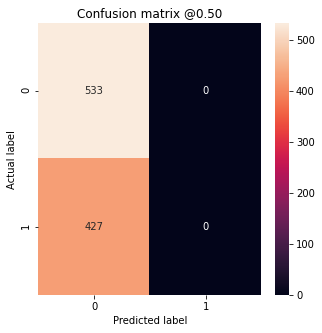

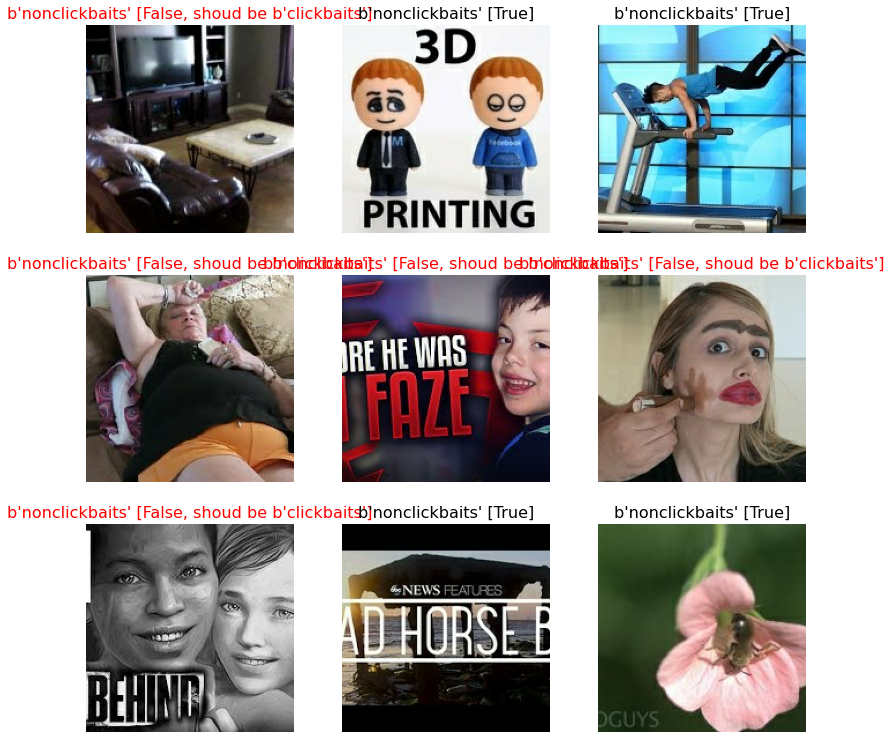

In [254]:
saved_model_vgg16_v3 = keras.models.load_model(vgg16_v3_model_path)
results = saved_model_vgg16_v3.evaluate(test_ds)

for name, value in zip(saved_model_vgg16_v3.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_vgg16_v3,test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

###V4

61/61 [==============================] - 6s 97ms/step - loss: 0.7024 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1052.0000 - fn: 896.0000 - accuracy: 0.5400 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4910 - prc: 0.4491
loss :  0.7023839354515076
tp :  0.0
fp :  0.0
tn :  1052.0
fn :  896.0
accuracy :  0.5400410890579224
precision :  0.0
recall :  0.0
auc :  0.4910077750682831
prc :  0.44906726479530334

Accuracy: 0.555208
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
ROC AUC: 0.500000
[[533   0]
 [427   0]]
Non clickbaits Detected (True Negatives):  533
Non-Clickbaits Detected as Clickbaits (False Positives):  0
Clickbaits Detected as Non-clickbaits (False Negatives):  427
Clickbaits Detected (True Positives):  0
Total Non-clickbaits:  533
Total Clickbaits:  427



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


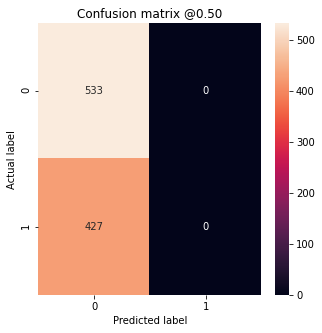

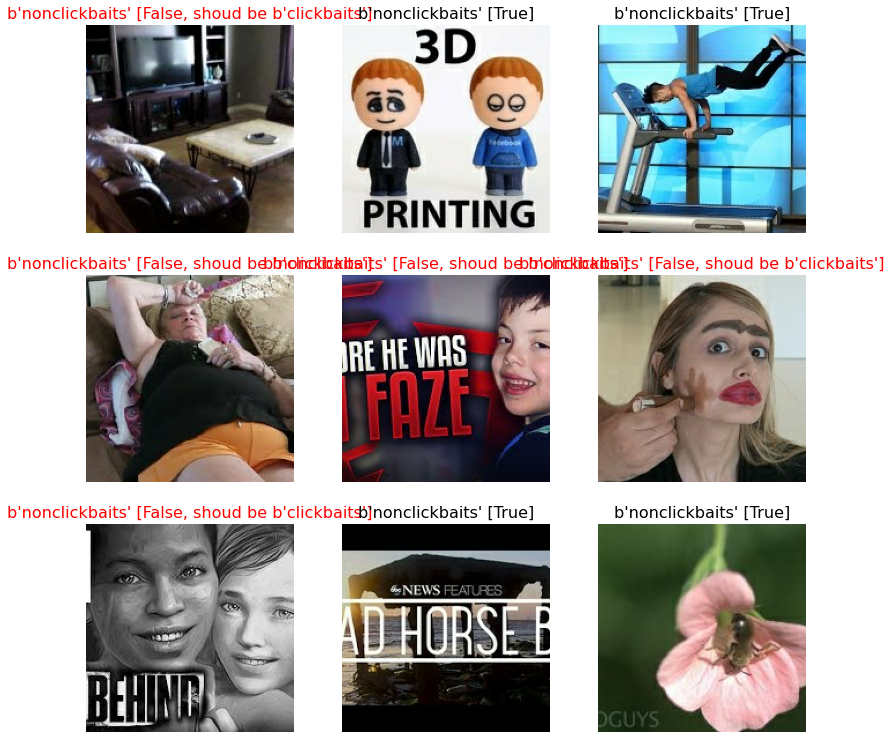

In [257]:
#saved_model_vgg16_v1_aug = keras.models.load_model(vgg16_v1_model_aug_path)
results = vgg16_v1_aug.evaluate(test_ds)

for name, value in zip(vgg16_v1_aug.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(vgg16_v1_aug, test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)